In [1]:
from glob import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from scipy.spatial.distance import pdist
from scipy.stats import spearmanr
from tqdm import tqdm
import seaborn as sns
from itertools import combinations
from src.tools import corr2d
import nibabel as nib
import warnings
from joblib import Parallel, delayed

from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import LeaveOneGroupOut

In [2]:
subj = 'sub-04'
stimulus_set = 'train'
process = 'fMRI_RSA'
decoding = True
calculate_rdm = True

top_path = '/Users/emcmaho7/Dropbox/projects/SI_EEG/SIEEG_analysis'
annotation_path = f'{top_path}/data/raw/annotations'
preproc_path = f'{top_path}/data/raw/fMRI_betas/'
preproc_file = f'{preproc_path}/{subj}_space-T1w_desc-{stimulus_set}-fracridge-all-data.nii.gz'
roi_path = f'{top_path}/data/raw/localizers/{subj}'
figure_path = f'{top_path}/reports/figures/{process}'
out_path = f'{top_path}/data/interim/{process}'
Path(figure_path).mkdir(parents=True, exist_ok=True)
Path(out_path).mkdir(parents=True, exist_ok=True)

In [3]:
video_df = pd.read_csv(f'{annotation_path}/{stimulus_set}.csv')
videos = video_df.sort_values('video_name').video_name.to_numpy()

In [4]:
rois = ['EVC', 'MT', 'EBA',
        'LOC', 'FFA', 'PPA',
        'pSTS', 'face-pSTS', 'aSTS']
feature_order = ['alexnet', 'moten', 'indoor',
                 'expanse', 'object_directedness', 'agent_distance',
                 'facingness', 'joint_action', 'communication', 
                 'valence', 'arousal']

## Pairwise decoding

In [5]:
def divide_into_groups(arr, n_groups=5):
    n = len(arr)
    
    # Calculate the size of each group
    group_size = n // n_groups
    remainder = n % n_groups
    
    groups = []
    start_idx = 0
    
    for i in range(n_groups):
        end_idx = start_idx + group_size + (i < remainder)  # Add 1 if this group takes an extra element
        group = arr[start_idx:end_idx]
        groups.append(group)
        start_idx = end_idx  # Update the starting index for the next group
        
    return groups

In [6]:
def generate_pseudo(arr, n_groups=5):
    inds = np.arange(len(arr))
    np.random.shuffle(inds)
    groups = divide_into_groups(inds, n_groups)
    pseudo_arr = []
    for group in groups:
        pseudo_arr.append(np.nanmean(arr[group], axis=0))
    return np.array(pseudo_arr)

In [7]:
def gen_mask(files, rel_mask):
    roi = []
    for f in files:
        roi_hemi = nib.load(f).get_fdata().astype('bool')
        roi.append(roi_hemi)
    roi_mask = np.sum(roi, axis=0).flatten()
    return np.all(np.vstack([rel_mask, roi_mask]), axis=0)

In [8]:
def fit_and_predict(arr1, arr2, n_groups):
    #regenerate to ensure that it is thread safe
    logo = LeaveOneGroupOut()
    pipe = Pipeline([('scale', StandardScaler()), ('lr', LogisticRegression())])

    #define X, y, and groups to loop through
    X = np.vstack([generate_pseudo(arr1),
                    generate_pseudo(arr2)])
    drop_inds = np.isclose(np.sum(np.isnan(X), axis=0), 0)
    X = X[:, drop_inds]
    y = np.hstack([np.zeros((n_groups)), np.ones((n_groups))]).astype('int')
    groups = np.concatenate([np.arange(n_groups), np.arange(n_groups)])

    #fit and predict 
    y_pred = []
    y_true = []
    for train_index, test_index in logo.split(X, y, groups=groups):
        pipe.fit(X[train_index], y[train_index])
        y_pred.append(pipe.predict(X[test_index]))
        y_true.append(y[test_index])
        
    #Return the mean prediction acurracy over all groups
    return np.mean(np.array(y_pred) == np.array(y_true))

In [9]:
if decoding:
    n_groups = 5 
    groups = np.concatenate([np.arange(n_groups), np.arange(n_groups)])
    logo = LeaveOneGroupOut()
    pipe = Pipeline([('scale', StandardScaler()), ('lr', LogisticRegression())])
    out_name = f'{out_path}/{subj}_set-{stimulus_set}_pairwise-decoding.csv'
else:
    out_name = f'{out_path}/{subj}_set-{stimulus_set}_correlation-distance.csv'

print(out_name)

/Users/emcmaho7/Dropbox/projects/SI_EEG/SIEEG_analysis/data/interim/fMRI_RSA/sub-04_set-train_pairwise-decoding.csv


In [10]:
if calculate_rdm:
    print(preproc_file)
    betas = nib.load(preproc_file)
    print(betas.shape)
    betas_flat = np.array(betas.dataobj).reshape((-1, betas.shape[-2], betas.shape[-1]))

    threshold = 0.235
    even = np.mean(betas_flat[..., 1::2], axis=-1).T
    odd = np.mean(betas_flat[..., ::2], axis=-1).T
    r_map = corr2d(even, odd)
    r_map[r_map < 0] = 0
    reliability_mask = (r_map >= threshold) & (~np.isnan(r_map))

    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", message="Mean of empty slice")
        
        nCk = list(combinations(range(betas_flat.shape[1]), 2))
        results = []
        for roi in tqdm(rois):
            files = glob(f'{roi_path}/{subj}_task-*_space-T1w_roi-{roi}_hemi-*_roi-mask.nii.gz')
            mask = gen_mask(files, reliability_mask)
            betas_masked = betas_flat[mask, ...]
            if decoding:
                result_for_t = Parallel(n_jobs=4)(
                    delayed(fit_and_predict)(betas_masked[:, video1, :].squeeze().T,
                                            betas_masked[:, video2, :].squeeze().T,
                                            n_groups) for video1, video2 in nCk
                )
                for accuracy, (video1, video2) in zip(result_for_t, nCk):
                    results.append([roi, videos[video1], videos[video2], accuracy])
            else:
                rdm = pdist(np.nanmean(betas_flat[mask, ...], axis=-1).T, metric='correlation')
                for i, (video1, video2) in enumerate(nCk):
                    results.append([roi, videos[video1], videos[video2],
                                    rdm[i]])
    results = pd.DataFrame(results, columns=['roi', 'video1', 'video2', 'distance'])
    results.to_csv(out_name, index=False)
else:
    results = pd.read_csv(out_name)

/Users/emcmaho7/Dropbox/projects/SI_EEG/SIEEG_analysis/data/raw/fMRI_betas//sub-04_space-T1w_desc-train-fracridge-all-data.nii.gz
(73, 94, 72, 200, 10)


/Users/emcmaho7/Dropbox/projects/SI_EEG/SIEEG_analysis/src/tools.py:36: RuntimeWarning: Mean of empty slice
  x_m = x - np.nanmean(x, axis=0)
/Users/emcmaho7/Dropbox/projects/SI_EEG/SIEEG_analysis/src/tools.py:37: RuntimeWarning: Mean of empty slice
  y_m = y - np.nanmean(y, axis=0)
100%|██████████| 9/9 [30:50<00:00, 205.66s/it]  


## Feature RDMs

Load the feature annotations and make the RDMs. Care needs to be paid to ensure that that the order of the vidoes across the two RDMs is consistent. 

In [11]:
features_to_exclude = ['dominance', 'cooperation', 'intimacy']
df = pd.read_csv(f'{annotation_path}/annotations.csv')
df = df.merge(pd.read_csv(f'{annotation_path}/{stimulus_set}.csv'), on='video_name').set_index('video_name')
df = df.drop(columns=features_to_exclude)
rename = {col: col.replace(' ', '_') for col in df.columns}
rename['transitivity'] = 'object_directedness'
df.rename(columns=rename, inplace=True)
df.sort_index(inplace=True)

alexnet = pd.read_csv(f'{top_path}/data/interim/ActivationPCA/alexnet_PCs.csv').drop(columns=['split'])
df = df.merge(alexnet, on='video_name')

moten = pd.read_csv(f'{top_path}/data/interim/ActivationPCA/moten_PCs.csv').drop(columns=['split'])
df = df.merge(moten, on='video_name')

df.head()

,video_name,indoor,expanse,object_directedness,agent_distance,facingness,joint_action,communication,valence,arousal,...,alexnet_PC13,alexnet_PC14,alexnet_PC15,alexnet_PC16,alexnet_PC17,alexnet_PC18,alexnet_PC19,moten_PC0,moten_PC1,moten_PC2
0,-YwZOeyAQC8_15.mp4,1,0.225,0.895833,0.000000,0.045455,0.700,0.550000,0.650000,0.340909,...,-1.082823,10.191237,-22.614979,20.582584,20.926926,19.438461,14.355835,7.659730,21.567951,4.739616
1,1AIVH5cEWrI_35.mp4,1,0.250,0.104167,0.075000,1.000000,0.825,0.900000,0.675000,0.340909,...,258.609620,-38.368233,-33.512670,58.147423,40.795100,-20.262676,-65.375340,-14.666296,-13.239152,3.911069
2,2-8-0-2-5-4-8-8-5028025488_7.mp4,1,0.275,1.000000,0.045455,0.050000,0.575,0.500000,0.675000,0.075000,...,30.271772,17.192259,-6.165896,4.899196,-7.362109,51.271584,2.212805,5.335573,3.574568,4.336222
3,7-5-1-0-3-6-9-8-3775103698_9.mp4,1,0.275,0.925000,0.275000,0.636364,0.750,0.825000,0.722222,0.125000,...,62.311256,10.069392,50.194890,-33.658016,-59.276447,-21.671180,58.144630,-10.635544,-2.401499,2.511829
4,8-6-0-3-9-6-6-0-19586039660_4.mp4,1,0.325,0.950000,0.227273,0.150000,0.425,0.727273,0.650000,0.350000,...,-13.609958,-8.555138,2.668892,20.188330,2.456507,13.187325,11.106343,-1.318197,16.211780,3.141062


In [12]:
videos_nCk = list(combinations(videos, 2))
feature_rdms = []
for feature in tqdm(feature_order):
    if 'alexnet' == feature or 'moten' == feature:
        cols = [col for col in df.columns if feature in col]
        array = df[cols].to_numpy()
        distance_matrix = pdist(array, metric='correlation')
    else: 
        array = np.expand_dims(df[feature].to_numpy(), axis=1)
        distance_matrix = pdist(array, metric='euclidean')
        
    for idx, (video1, video2) in enumerate(videos_nCk):
        feature_rdms.append([video1, video2, feature, distance_matrix[idx]])
feature_rdms = pd.DataFrame(feature_rdms, columns=['video1', 'video2', 'feature', 'distance'])
feature_rdms.head()

100%|██████████| 11/11 [00:00<00:00, 22.61it/s]


,video1,video2,feature,distance
0,-YwZOeyAQC8_15.mp4,1AIVH5cEWrI_35.mp4,alexnet,1.120146
1,-YwZOeyAQC8_15.mp4,2-8-0-2-5-4-8-8-5028025488_7.mp4,alexnet,0.844553
2,-YwZOeyAQC8_15.mp4,7-5-1-0-3-6-9-8-3775103698_9.mp4,alexnet,1.105170
3,-YwZOeyAQC8_15.mp4,8-6-0-3-9-6-6-0-19586039660_4.mp4,alexnet,0.478400
4,-YwZOeyAQC8_15.mp4,9jw7D-exQDg_77.mp4,alexnet,1.277775


## Correlate Feature and Neural RDMs

In [13]:
feature_group = feature_rdms.groupby('feature')
neural_group = results.groupby('roi')
rsa = []
for feature, feature_rdm in tqdm(feature_group):
    for time, time_rdm in neural_group:
        rho, _ = spearmanr(feature_rdm.distance, time_rdm.distance)
        rsa.append([feature, time, rho])
rsa = pd.DataFrame(rsa, columns=['feature', 'roi', 'Spearman rho'])
cat_type = pd.CategoricalDtype(categories=feature_order, ordered=True)
rsa['feature'] = rsa.feature.astype(cat_type)
cat_type = pd.CategoricalDtype(categories=rois, ordered=True)
rsa['roi'] = rsa.roi.astype(cat_type)
if decoding: 
    rsa.to_csv(f'{out_path}/{subj}_set-{stimulus_set}_rsa-decoding.csv')
else:
    rsa.to_csv(f'{out_path}/{subj}_set-{stimulus_set}_rsa-correlation.csv')
rsa.head()

100%|██████████| 11/11 [00:01<00:00,  7.94it/s]


,feature,roi,Spearman rho
0,agent_distance,EBA,0.046637
1,agent_distance,EVC,0.022447
2,agent_distance,FFA,0.030098
3,agent_distance,LOC,0.049377
4,agent_distance,MT,0.035918


In [14]:
def feature2color(key=None):
    d = dict()
    d['alexnet'] = np.array([0.5, 0.5, 0.5, 1])
    d['moten'] = np.array([0.5, 0.5, 0.5, 1])
    d['indoor'] = np.array([0.95703125, 0.86328125, 0.25, 0.8])
    d['expanse'] = np.array([0.95703125, 0.86328125, 0.25, 0.8])
    d['object_directedness'] = np.array([0.95703125, 0.86328125, 0.25, 0.8])
    d['agent_distance'] = np.array([0.51953125, 0.34375, 0.953125, 0.8])
    d['facingness'] = np.array([0.51953125, 0.34375, 0.953125, 0.8])
    d['joint_action'] = np.array([0.44921875, 0.8203125, 0.87109375, 0.8])
    d['communication'] = np.array([0.44921875, 0.8203125, 0.87109375, 0.8])
    d['valence'] = np.array([0.8515625, 0.32421875, 0.35546875, 0.8])
    d['arousal'] = np.array([0.8515625, 0.32421875, 0.35546875, 0.8])
    if key is not None:
        return d[key]
    else:
        return d

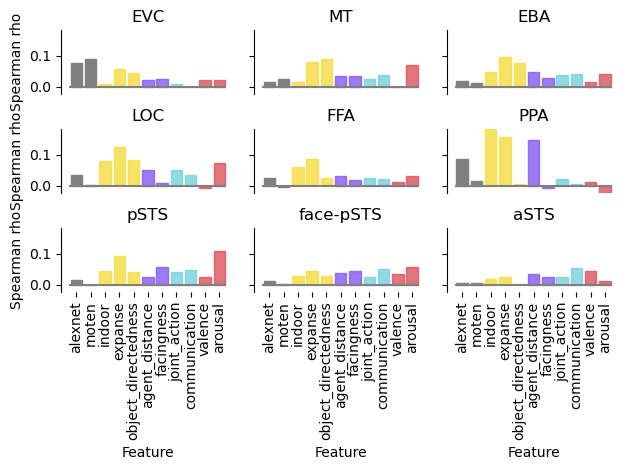

In [15]:
feature_group = rsa.groupby('roi')
_, axes = plt.subplots(3, 3, sharey=True, sharex=True)
axes = axes.flatten()
ymin, ymax = rsa['Spearman rho'].min(), rsa['Spearman rho'].max()
for ax, (roi, feature_df) in zip(axes, feature_group):
    sns.barplot(x='feature', y='Spearman rho',
                 data=feature_df, ax=ax, color='gray')
    if roi in ['EVC', 'LOC', 'pSTS']:
        ax.set_ylabel('Spearman rho')
    else:
        ax.set_ylabel('')
        
    if roi in ['pSTS', 'face-pSTS', 'aSTS']:
        ax.set_xlabel('Feature')
        ax.set_xticklabels(feature_order, rotation=90, ha='center')
    else:
        ax.set_xlabel('')
        ax.tick_params(axis='x', which='both', length=0)

    for bar, feature in zip(ax.patches, feature_order):
        color = feature2color(feature)
        bar.set_color(color)
        
    ax.set_ylim([ymin, ymax])
    ax.hlines(y=0, xmin=ax.get_xlim()[0], xmax=ax.get_xlim()[1],
        colors='gray', linestyles='solid', zorder=1)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.set_title(roi)
plt.tight_layout()
if decoding: 
    plt.savefig(f'{figure_path}/{subj}_set-{stimulus_set}_rsa-decoding.png')
else:
    plt.savefig(f'{figure_path}/{subj}_set-{stimulus_set}_rsa-correlation.png')